In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from collections import defaultdict

In [2]:

df1 = pd.read_csv('datatraining.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)

df2= pd.read_csv('datatest.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)

df3= pd.read_csv('datatest2.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)

df4= pd.merge(df2, df1, how='outer')

df=pd.merge(df4, df3, how='outer')
df = df.set_index(['date'])
df.head()
df.shape

(20560, 6)

In [3]:
del df["HumidityRatio"]

# CLUSTERING

In [7]:
from tslearn.clustering import TimeSeriesKMeans

C:\Users\monia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [8]:
index1=np.random.choice(df.index,20460,replace=False)
df1=df.drop(index=index1,axis=0)

In [9]:
attributes = [col for col in df.columns if col != 'Occupancy']
X = df1[attributes].values

In [10]:
X =X.T
X.shape

(4, 100)

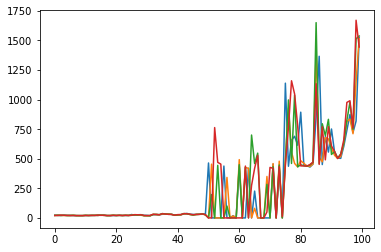

In [123]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

In [126]:
km = TimeSeriesKMeans(n_clusters=2, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=2, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

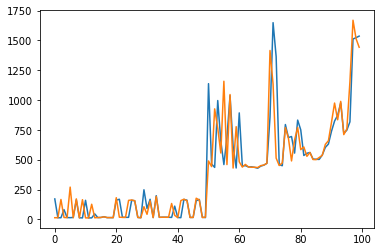

In [127]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 2))
plt.show()

In [21]:
km.labels_

array([0, 0, 0, 1], dtype=int64)

In [22]:
km.inertia_ #Si intende per “inerzia interna ad un gruppo (within group)” il valore dello scarto quadratico medio dei dati appartenenti a quel gruppo. 
            #Esso è un indice di quanto i dati interni ad un gruppo si discostano dal valor medio relativo a quello stesso gruppo.

996938.4754113426

In [23]:
km_dtw = TimeSeriesKMeans(n_clusters=2, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=2, n_init=1, n_jobs=None, random_state=0, tol=1e-06,
                 verbose=0)

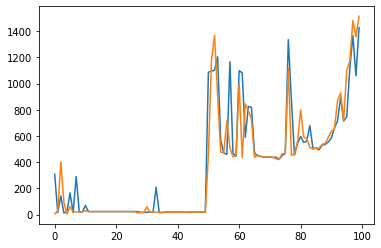

In [24]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 2))
plt.show()

In [25]:
km_dtw.labels_

array([0, 0, 0, 1], dtype=int64)

In [26]:
km_dtw.inertia_

701905.3879984678

# Feature Based Cluster

In [4]:
from sklearn.cluster import KMeans

In [5]:
import numpy as np
import scipy.stats as stats
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [11]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [12]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
kmeans.inertia_

1046577231.1573164

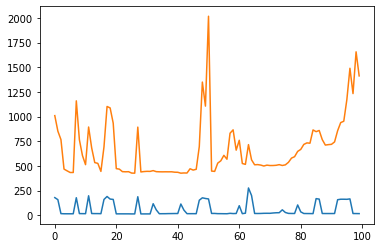

In [14]:
for i in range(2):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

# Compression Based Clustering

In [85]:
from sklearn.metrics import pairwise_distances
import zlib
import string

In [86]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [87]:
index1=np.random.choice(df.index,20460,replace=False)
df1=df.drop(index=index1,axis=0)
attributes = [col for col in df.columns if col != 'Occupancy']
X = df1[attributes].values
X =X.T
X.shape

(4, 100)

In [102]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)
M.shape

(4, 4)

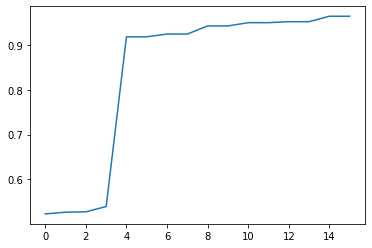

In [103]:
plt.plot(sorted(M.ravel()))
plt.show()

In [90]:
from sklearn.cluster import DBSCAN

In [108]:
dbscan = DBSCAN(eps=0.9, min_samples=8, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.9, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=8, n_jobs=None, p=None)

In [109]:
dbscan.labels_

array([-1, -1, -1, -1], dtype=int64)

### Approximated Clustering

In [107]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

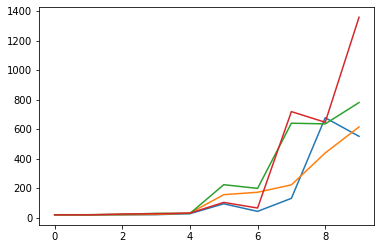

In [111]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

In [130]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X_paa)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=3, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

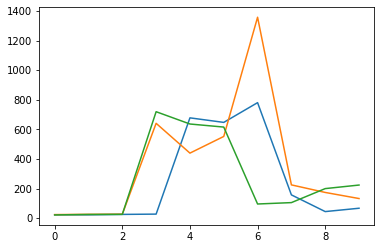

In [131]:
plt.plot(km.cluster_centers_.reshape(X_paa.shape[1], 3))
plt.show()

In [132]:
km.labels_

array([0, 0, 2, 1], dtype=int64)

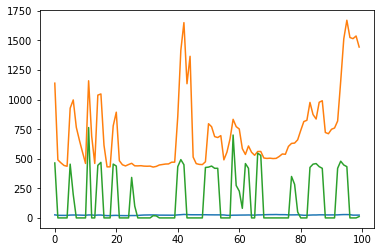

In [133]:
for i in range(3):
    plt.plot(np.mean(X[np.where(km.labels_ == i)[0]], axis=0))
plt.show()